# Dataloader for Contrastive Loss

This notebook implements the dataloader needed for training the Siamese network later.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1" #to suppress some unnecessary warnings
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from Utilities import DataLoaderContrastive, get_dataset_with_prefetching

# Load all the classes and their images.

In [2]:
dataset_root_path = "lfw_funneled"
similar_classes_paths = []
dissimilar_classes_paths = []

for class_dir in os.scandir(dataset_root_path):
    files = os.listdir(class_dir.path)
    
    if len(files) > 1:
        # this path contains more than one file (image) of the same class (person)
        similar_classes_paths.append([])
        for file in files:
            similar_classes_paths[-1].append(os.path.join(class_dir.path, file))
    else:
        # this path conatins only one file (image) of the same class (person)
        dissimilar_classes_paths.append([])
        dissimilar_classes_paths[-1].append(os.path.join(class_dir.path, files[0]))

print(f"{len(similar_classes_paths)} similar classes, {len(dissimilar_classes_paths)} dissimilar classes.")

1680 similar classes, 4069 dissimilar classes.


Test the **Data Loader**

In [3]:
train_loader = DataLoaderContrastive(dataset_root_path, 32, (250, 250))

# Display a sample batch

input batch shape is (2, 250, 250, 3)
output batch shape is (32, 1)
label is : 1.0


C:\Users\sw\AppData\Local\Temp\ipykernel_10436\1979169881.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i)


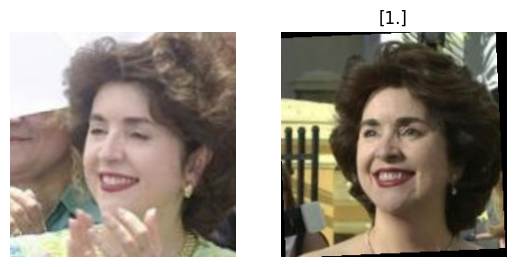

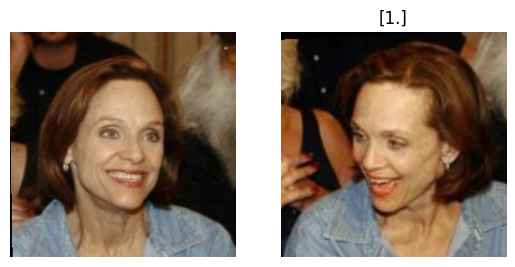

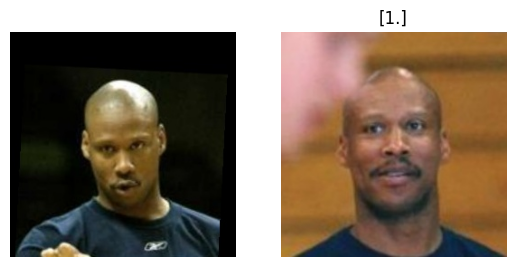

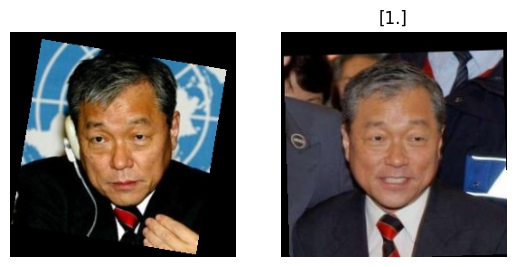

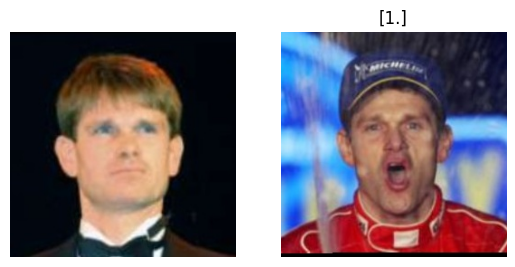

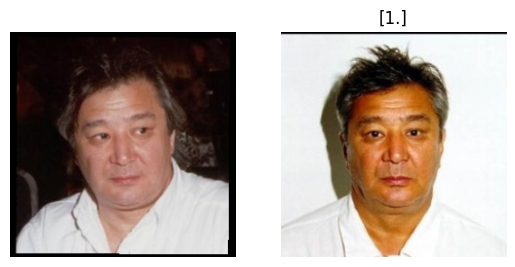

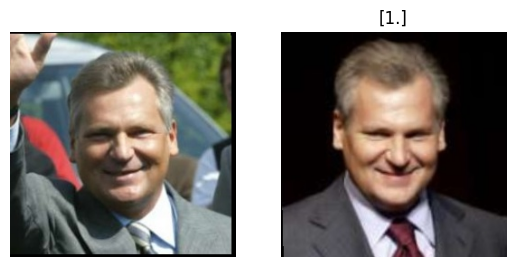

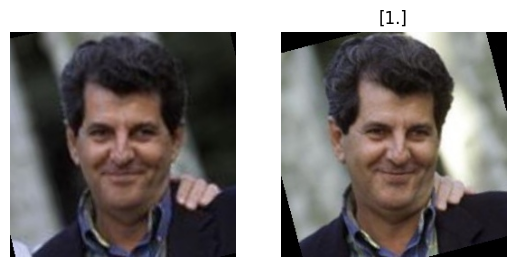

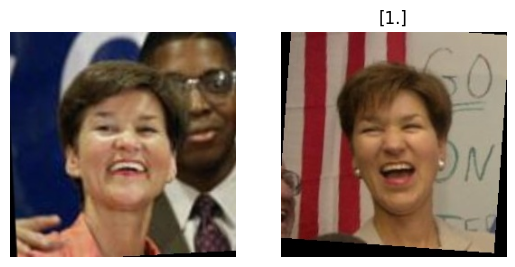

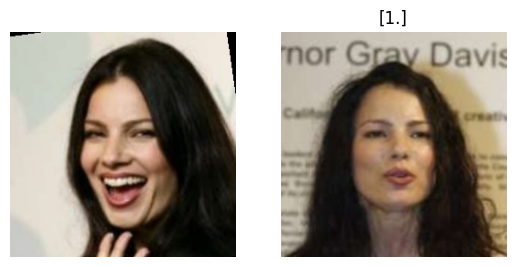

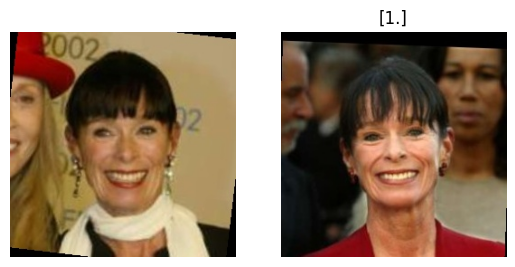

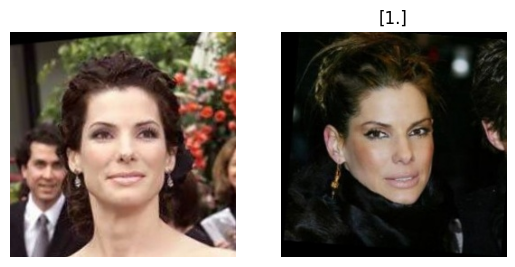

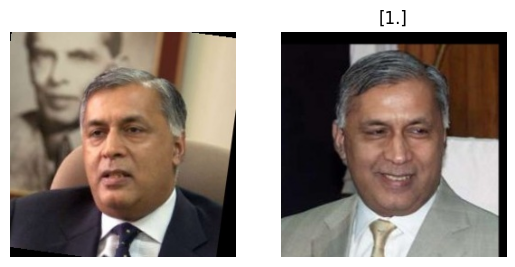

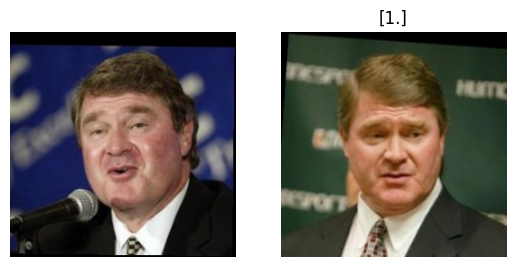

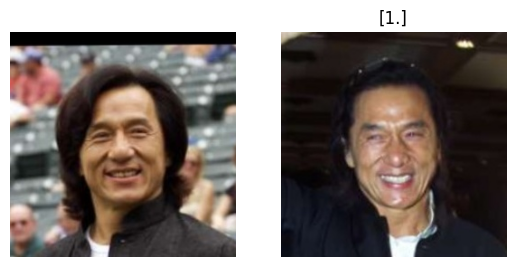

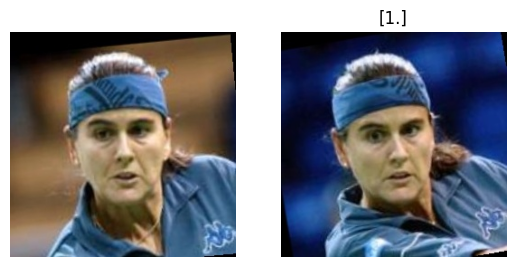

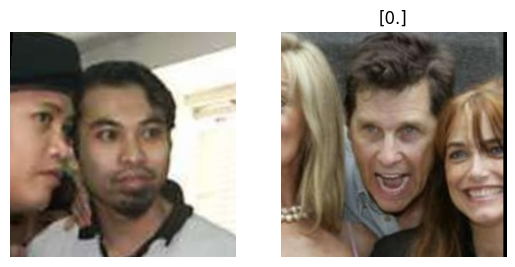

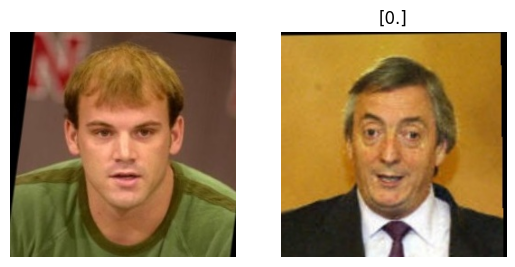

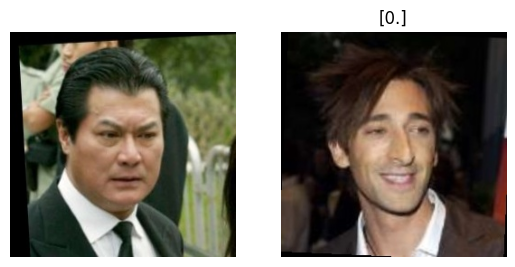

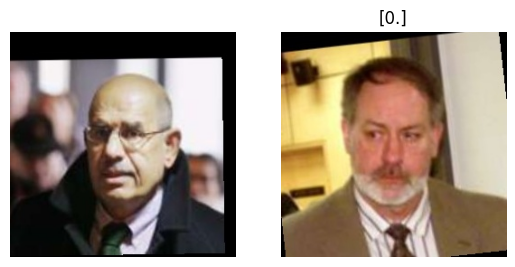

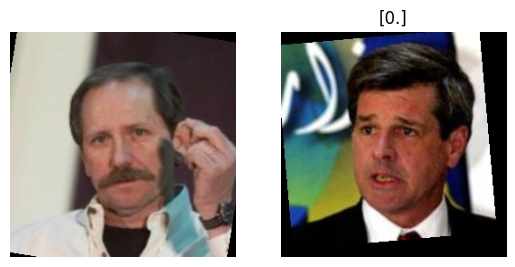

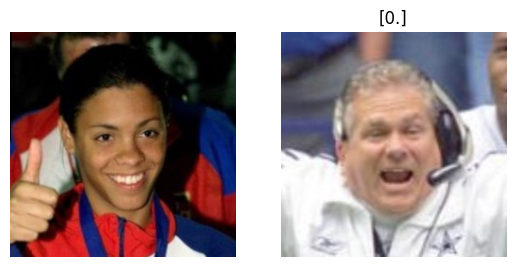

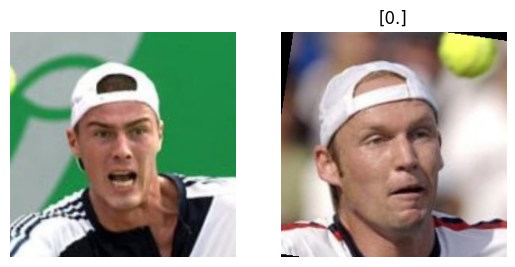

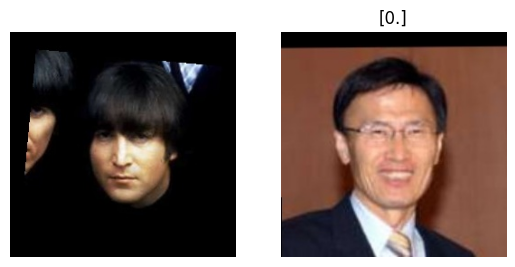

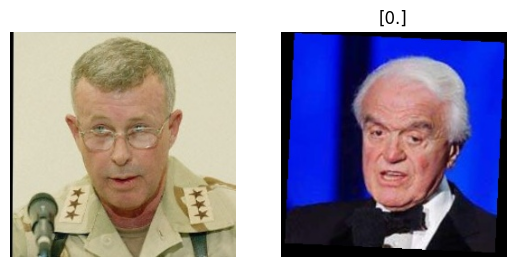

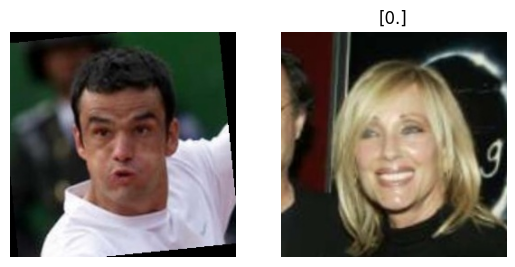

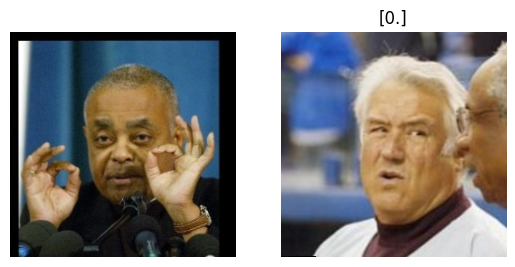

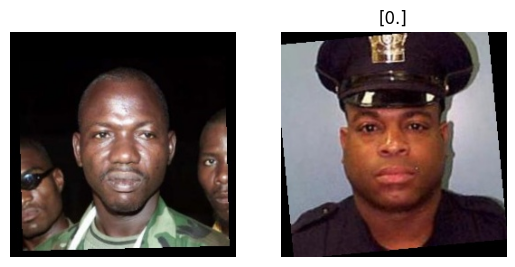

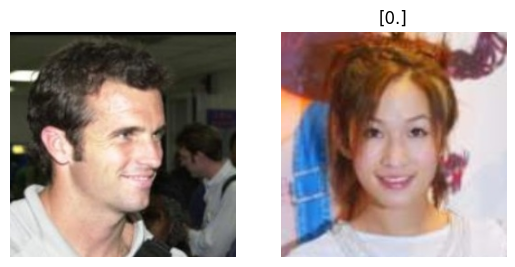

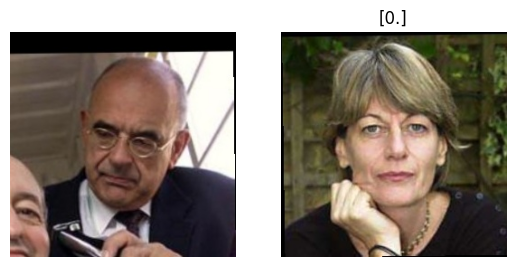

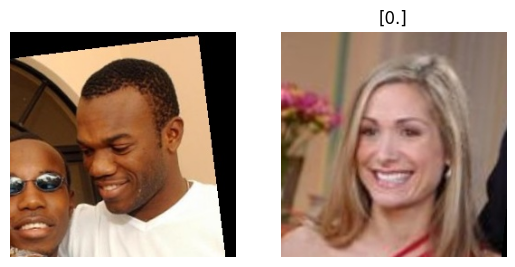

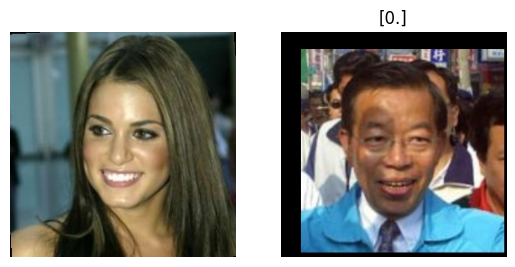

In [4]:
# get sample batch
(X1, X2), Y = train_loader[random.randint(0, len(train_loader)-1)]

# get sample pair
x1 = X1[0]
x2 = X2[0]
y_label = Y[0]

print(f"input batch shape is {np.concatenate([[x1], [x2]], axis = 0).shape}")
print(f"output batch shape is {Y.shape}")
print(f"label is : {y_label[0]}")

# show the whole batch
for i in range(len(X1)):

    x1 = X1[i]
    x2 = X2[i]
    y_label = Y[i]

    plt.figure(i)

    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(x1)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(x2)

    plt.title(y_label)

plt.show()

## Real Example

In [5]:
Input1 = keras.layers.Input(shape = (250, 250, 3))
Input2 = keras.layers.Input(shape = (250, 250, 3))
flatten1 = keras.layers.Flatten()(Input1)
flatten2 = keras.layers.Flatten()(Input2)
feature_vector = keras.layers.Concatenate()([flatten1, flatten2])
clf_head = keras.layers.Dense(32, 'relu')(feature_vector)
output = keras.layers.Dense(1, 'sigmoid')(clf_head)

model = keras.Model(inputs = [Input1, Input2], outputs = output)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


I0000 00:00:1732790007.990270   31959 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5666 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


Note that the high accuracy is not due to the fact that the model is good. <br> 
It is rather because the model mostly outputs a 0 most of the time since the majority of examples are negative. 

To do:
* Fix the dataset imbalance

In [6]:
train_loader = DataLoaderContrastive(dataset_path=dataset_root_path, batch_size=32, input_shape=(250, 250))

model.fit(train_loader, epochs = 2)

Epoch 1/2


/home/thoalfeqar/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1732790010.627807   32060 service.cc:148] XLA service 0x7e00cc003270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732790010.627832   32060 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
I0000 00:00:1732790010.795909   32060 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/180 ━━━━━━━━━━━━━━━━━━━━ 3:09 1s/step - accuracy: 0.0625 - loss: 0.7454

I0000 00:00:1732790011.001291   32060 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.9378 - loss: 7.6467
Epoch 2/2
180/180 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.9697 - loss: 0.2299


Test the model on an example:

In [7]:
(X1, X2), y = train_loader[0]
x1, x2, y = X1[0], X2[0], y[0]

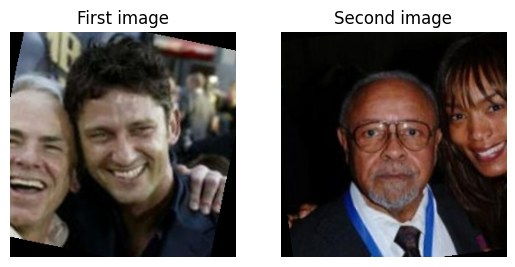

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.axis('off')
plt.title("First image")

plt.subplot(1, 2, 2)
plt.imshow(x2)
plt.axis('off')
plt.title("Second image")

plt.show()

In [9]:
model.predict(x = [np.expand_dims(x1, axis = 0), np.expand_dims(x2, axis = 0)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


array([[0.03806652]], dtype=float32)

## Optimize the data loader using tensorflow prefetching

In [10]:
#This is how to turn the regular dataloader into a tensorflow dataset with prefetching enabled
#
# dataset = tf.data.Dataset.from_generator(
#         DataLoader, 
#         args = [dataset_root_path, 32, (250, 250)], 
#         output_signature = ((tf.TensorSpec(shape = (32, 250, 250, 3), dtype = tf.float32), tf.TensorSpec(shape = (32, 250, 250, 3), dtype = tf.float32)), tf.TensorSpec(shape = (32, 1), dtype = tf.float32))
# ).prefetch(tf.data.AUTOTUNE)


#Use the function implemented in the Utilities file instead
dataset = get_dataset_with_prefetching(dataset_root_path)
model.fit(dataset, epochs = 3)

Epoch 1/3


180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.9705 - loss: 0.1572
Epoch 2/3


/home/thoalfeqar/anaconda3/envs/tf/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.9647 - loss: 0.1728
Epoch 3/3
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9675 - loss: 0.1529
